In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, accuracy_score
from statsmodels.stats.multitest import multipletests
%load_ext autoreload
%autoreload 2

In [2]:
pd.set_option('precision', 3)

In [3]:
def compute_roc_auc(y_true, y_pred):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    return roc_auc


def compute_pr_auc(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    return pr_auc


def plot_roc_curve(y_true, y_pred, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(fpr, tpr, lw=1, ax=ax, alpha=0.3, label="{} - AUC: %0.2f".format(label) % (roc_auc))


def plot_pr_curve(y_true, y_pred, label, ax):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    sns.lineplot(recall, precision, lw=1, alpha=0.3, ax=ax, label="{} - AUC: %0.2f".format(label) % (pr_auc))
    
def customise_roc_pr_plots(axes, label_size=15, font_size=15, linewidth=5, patch_size=20):
    # Customizing plots
    for ax in axes:
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)

        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(font_size)

        plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))
        plt.setp(ax.lines, linewidth=linewidth)

    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')

    for ax in axes:
        for axis in [ax.xaxis, ax.yaxis]:
            axis.label.set_size(font_size)

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')

    for ax in axes:
        ax.legend(loc='best', prop={'size': patch_size})

In [4]:
cols = ["Model Name", "Accuracy", "ROC AUC", "PR AUC", "Criteria"]
folds = ["1", "2", "3", "4", "5"]

In [5]:
model_results = "/data03/christopher/m6anet_new_dataprep_results/"
df = []
save_per_epoch = 1
for model in os.listdir(model_results):
    model_dir = os.path.join(model_results, model)
    test_results = joblib.load(os.path.join(model_dir, "test_results.joblib"))
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        test_loss = [test_results[selection_criterion][i] for i in range (0, len(test_results[selection_criterion]), 
                                                                          save_per_epoch)]

        if selection_criterion == 'avg_loss':
            best_model = (np.argmin(test_loss) + 1) * save_per_epoch
        else:
            best_model = (np.argmax(test_loss) + 1) * save_per_epoch
            
        result = joblib.load(os.path.join(model_dir, "val_results_{}.joblib".format(selection_criterion)))
        y_true, y_pred = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion, best_model])
df = pd.DataFrame(df, columns=["Model Name", "Accuracy", "ROC AUC", "PR AUC", "Criteria", "Epoch of best model"])
df

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria,Epoch of best model
0,prod_pooling_summary_stats_1_neighbor_normal,0.954,0.773,0.281,avg_loss,2
1,prod_pooling_summary_stats_1_neighbor_normal,0.954,0.901,0.441,roc_auc,77
2,prod_pooling_summary_stats_1_neighbor_normal,0.956,0.901,0.459,pr_auc,67
3,prod_pooling_attention_1_neighbor_correlation_2,0.885,0.916,0.472,avg_loss,2
4,prod_pooling_attention_1_neighbor_correlation_2,0.896,0.918,0.471,roc_auc,9
5,prod_pooling_attention_1_neighbor_correlation_2,0.884,0.917,0.473,pr_auc,2
6,prod_pooling_attention_1_neighbor_regularized_...,0.864,0.894,0.378,avg_loss,1
7,prod_pooling_attention_1_neighbor_regularized_...,0.893,0.921,0.494,roc_auc,22
8,prod_pooling_attention_1_neighbor_regularized_...,0.880,0.916,0.505,pr_auc,36
9,prod_pooling_attention_1_neighbor_regularized_...,0.893,0.903,0.385,avg_loss,2


In [10]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "summary_stats_logit"
models = [model for model in all_models if model_type in model]
df = []
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
3,summary_stats_logit_5_neighbor,0.871,0.870,0.353,avg_loss
12,summary_stats_logit_4_neighbor,0.860,0.869,0.370,avg_loss
10,summary_stats_logit_0_neighbor,0.798,0.878,0.378,roc_auc
11,summary_stats_logit_0_neighbor,0.791,0.878,0.378,pr_auc
9,summary_stats_logit_0_neighbor,0.807,0.878,0.378,avg_loss
0,summary_stats_logit_3_neighbor,0.849,0.887,0.401,avg_loss
5,summary_stats_logit_5_neighbor,0.839,0.893,0.405,pr_auc
4,summary_stats_logit_5_neighbor,0.836,0.894,0.405,roc_auc
2,summary_stats_logit_3_neighbor,0.831,0.896,0.411,pr_auc
15,summary_stats_logit_1_neighbor,0.844,0.901,0.412,avg_loss


LogisticRegression_3_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LogisticRegression_5_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LogisticRegression_2_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LogisticRegression_0_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LogisticRegression_4_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


LogisticRegression_1_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


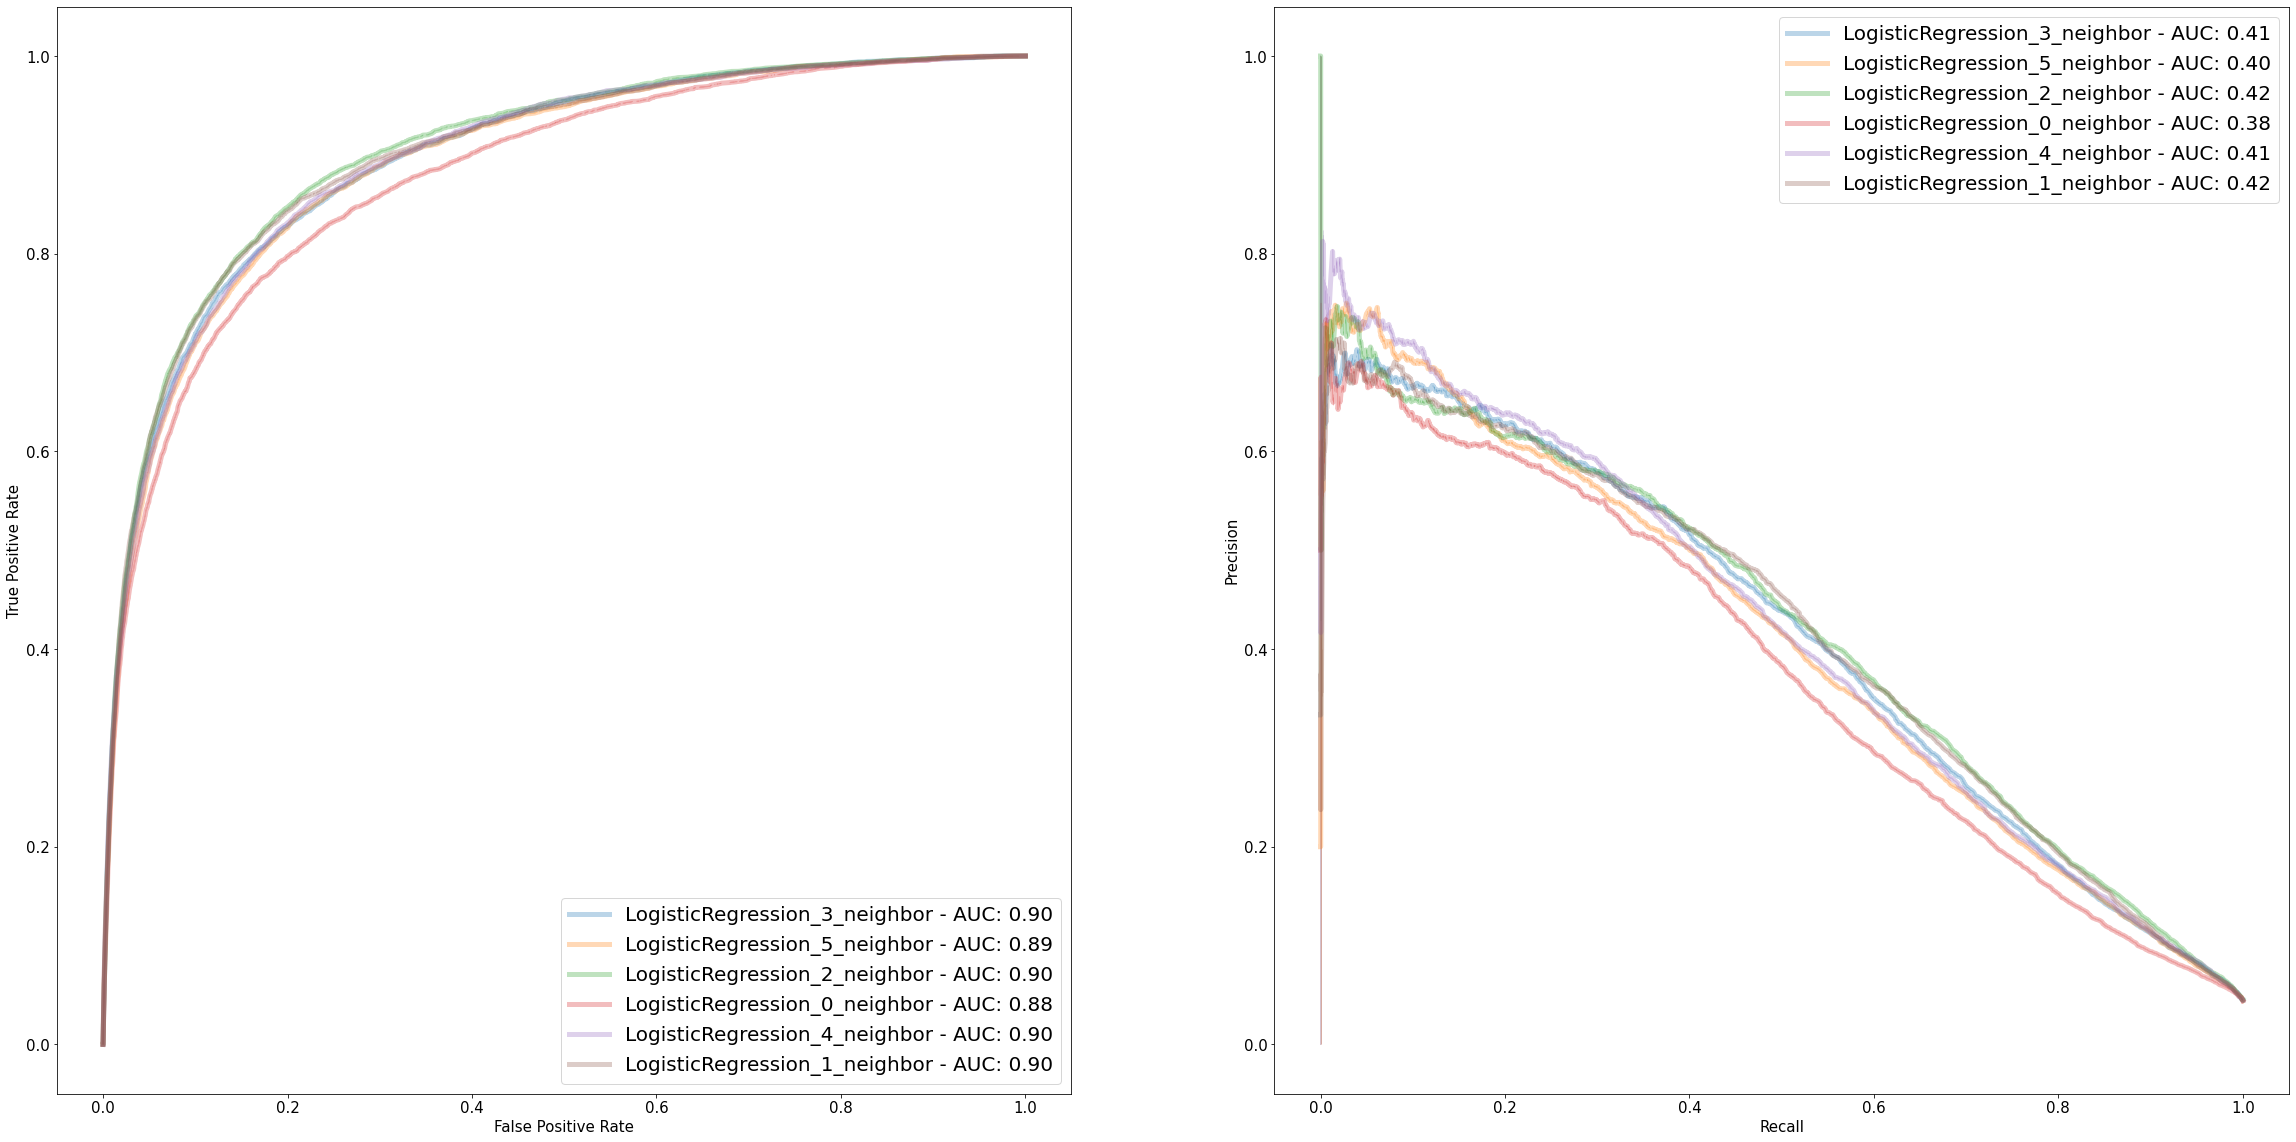

In [5]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "summary_stats_logit"
models = [model for model in all_models if model_type in model]
df = []
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        label = "LogisticRegression_{}_neighbor".format(model.split("_")[-2])
        print(label)
        plot_roc_curve(y_true, y_pred, label, axes[0])
        plot_pr_curve(y_true, y_pred, label, axes[1])
customise_roc_pr_plots(axes)

In [6]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "mil_logit"
models = [model for model in all_models if model_type in model]
df = []
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
0,mil_logit_5_neighbor,0.878,0.879,0.363,avg_loss
15,mil_logit_4_neighbor,0.866,0.879,0.373,avg_loss
17,mil_logit_4_neighbor,0.857,0.886,0.387,pr_auc
16,mil_logit_4_neighbor,0.844,0.890,0.390,roc_auc
10,mil_logit_0_neighbor,0.807,0.881,0.391,roc_auc
7,mil_logit_1_neighbor,0.830,0.894,0.392,roc_auc
11,mil_logit_0_neighbor,0.800,0.879,0.392,pr_auc
9,mil_logit_0_neighbor,0.813,0.881,0.392,avg_loss
6,mil_logit_1_neighbor,0.834,0.894,0.392,avg_loss
8,mil_logit_1_neighbor,0.831,0.894,0.393,pr_auc


In [11]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "summary_stats_nn"
models = [model for model in all_models if model_type in model]
df = []
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
3,summary_stats_nn_5_neighbor,0.941,0.866,0.381,avg_loss
5,summary_stats_nn_5_neighbor,0.885,0.879,0.385,pr_auc
8,summary_stats_nn_4_neighbor,0.898,0.876,0.390,pr_auc
4,summary_stats_nn_5_neighbor,0.871,0.882,0.391,roc_auc
6,summary_stats_nn_4_neighbor,0.944,0.882,0.398,avg_loss
15,summary_stats_nn_3_neighbor,0.947,0.885,0.403,avg_loss
17,summary_stats_nn_3_neighbor,0.903,0.867,0.405,pr_auc
7,summary_stats_nn_4_neighbor,0.858,0.894,0.409,roc_auc
9,summary_stats_nn_2_neighbor,0.944,0.889,0.411,avg_loss
13,summary_stats_nn_0_neighbor,0.858,0.900,0.427,roc_auc


NeuralNetwork_1_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_5_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_4_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_2_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_0_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_3_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


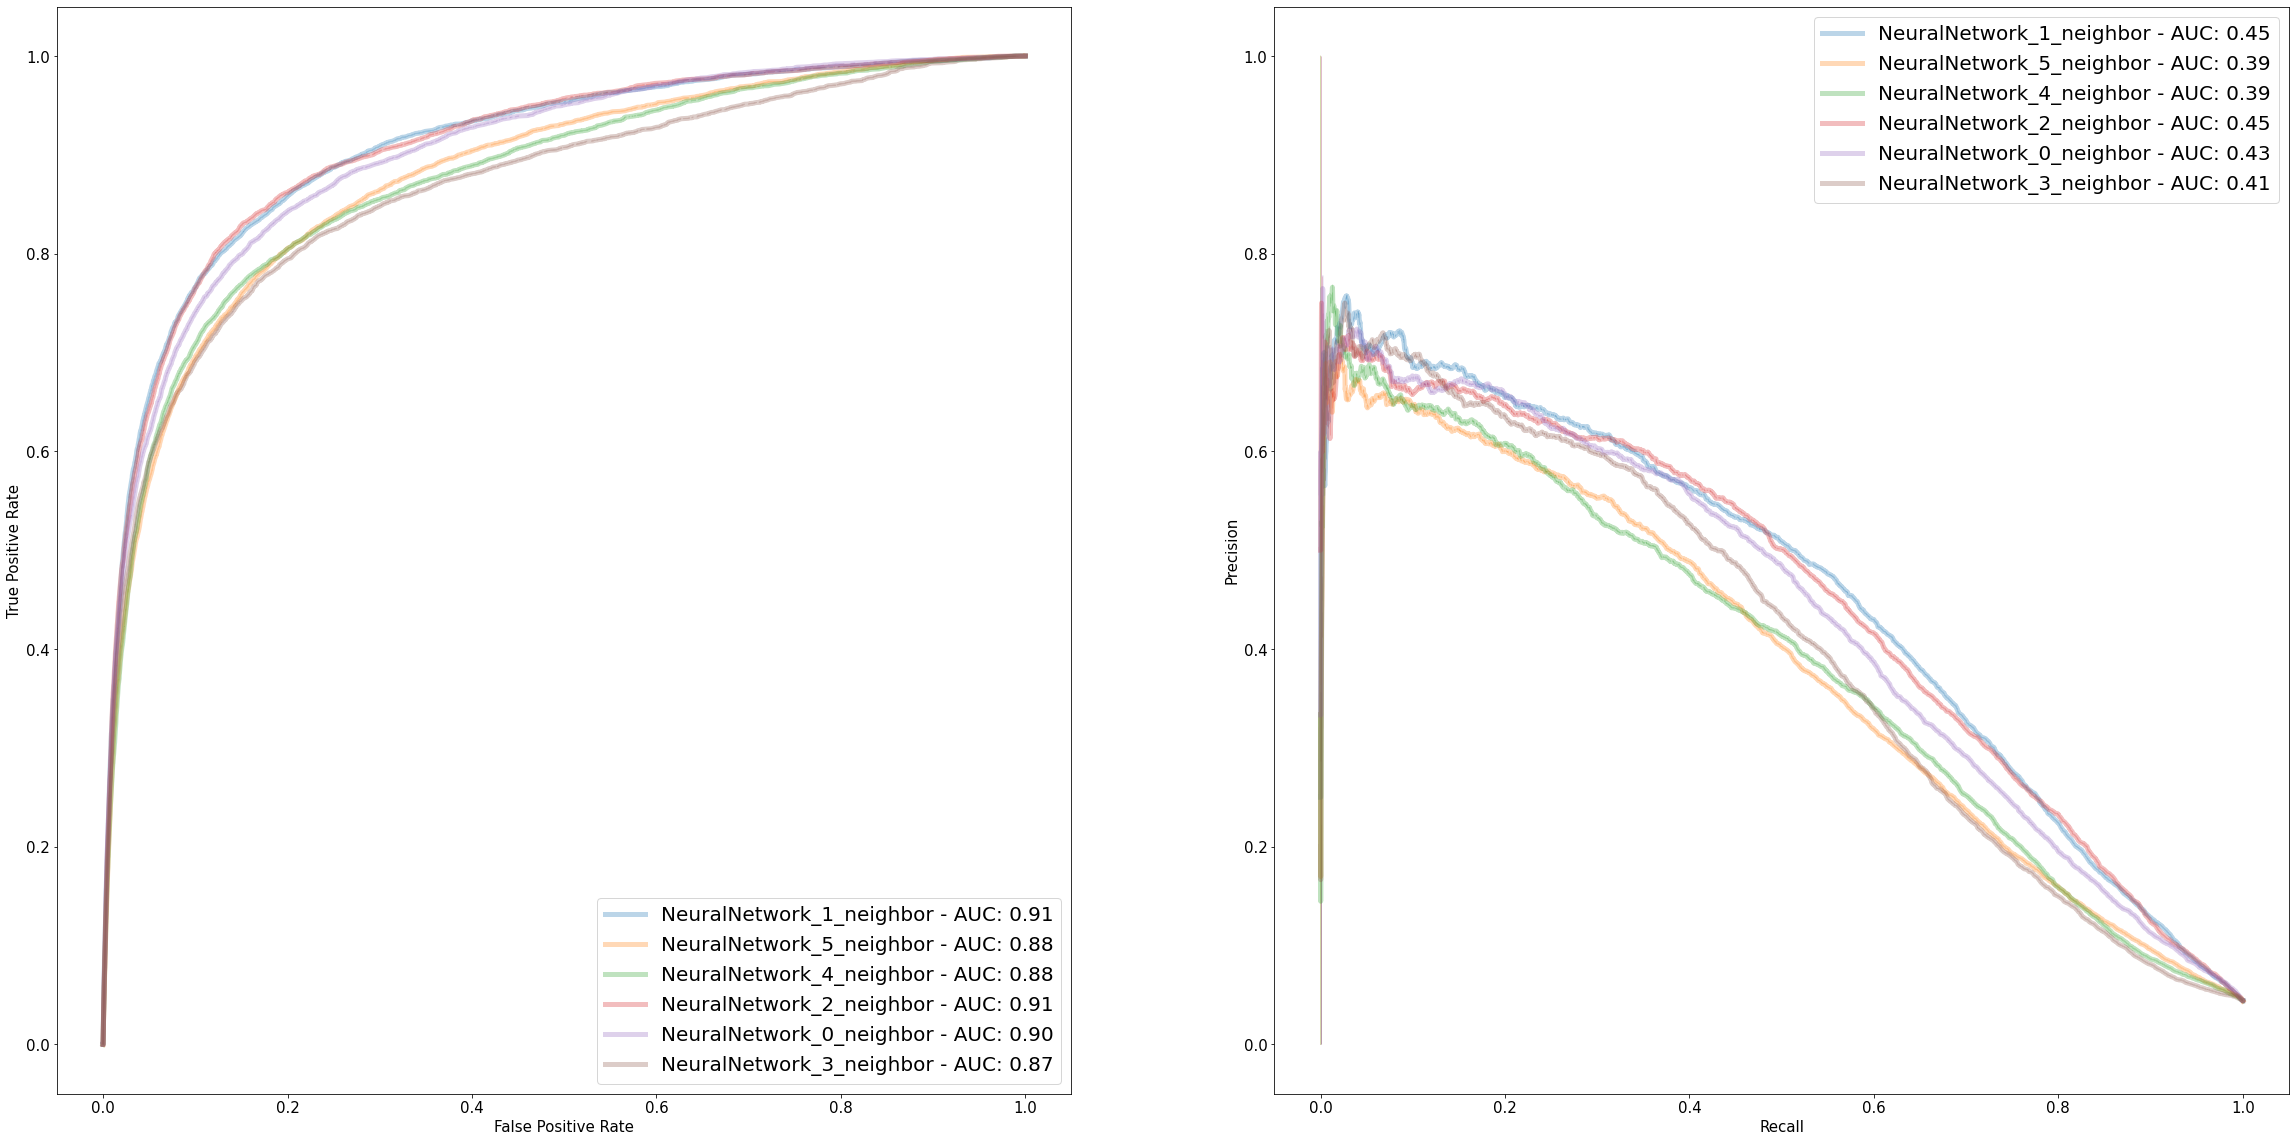

In [7]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "summary_stats_nn"
models = [model for model in all_models if model_type in model]
df = []
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        label = "NeuralNetwork_{}_neighbor".format(model.split("_")[-2])
        print(label)
        plot_roc_curve(y_true, y_pred, label, axes[0])
        plot_pr_curve(y_true, y_pred, label, axes[1])
customise_roc_pr_plots(axes)

In [16]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "prod_pooling"
models = ['prod_pooling_{}_neighbor'.format(i) for i in range(1, 6, 1)]
df = []
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
12,prod_pooling_5_neighbor,0.937,0.823,0.217,avg_loss
6,prod_pooling_3_neighbor,0.937,0.848,0.253,avg_loss
9,prod_pooling_4_neighbor,0.937,0.848,0.285,avg_loss
3,prod_pooling_2_neighbor,0.934,0.856,0.296,avg_loss
13,prod_pooling_5_neighbor,0.871,0.902,0.430,roc_auc
7,prod_pooling_3_neighbor,0.886,0.905,0.431,roc_auc
14,prod_pooling_5_neighbor,0.868,0.902,0.432,pr_auc
10,prod_pooling_4_neighbor,0.883,0.906,0.439,roc_auc
11,prod_pooling_4_neighbor,0.868,0.906,0.441,pr_auc
8,prod_pooling_3_neighbor,0.876,0.908,0.442,pr_auc


NeuralNetwork_Product_Pooling_1_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_2_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_3_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_4_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_5_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


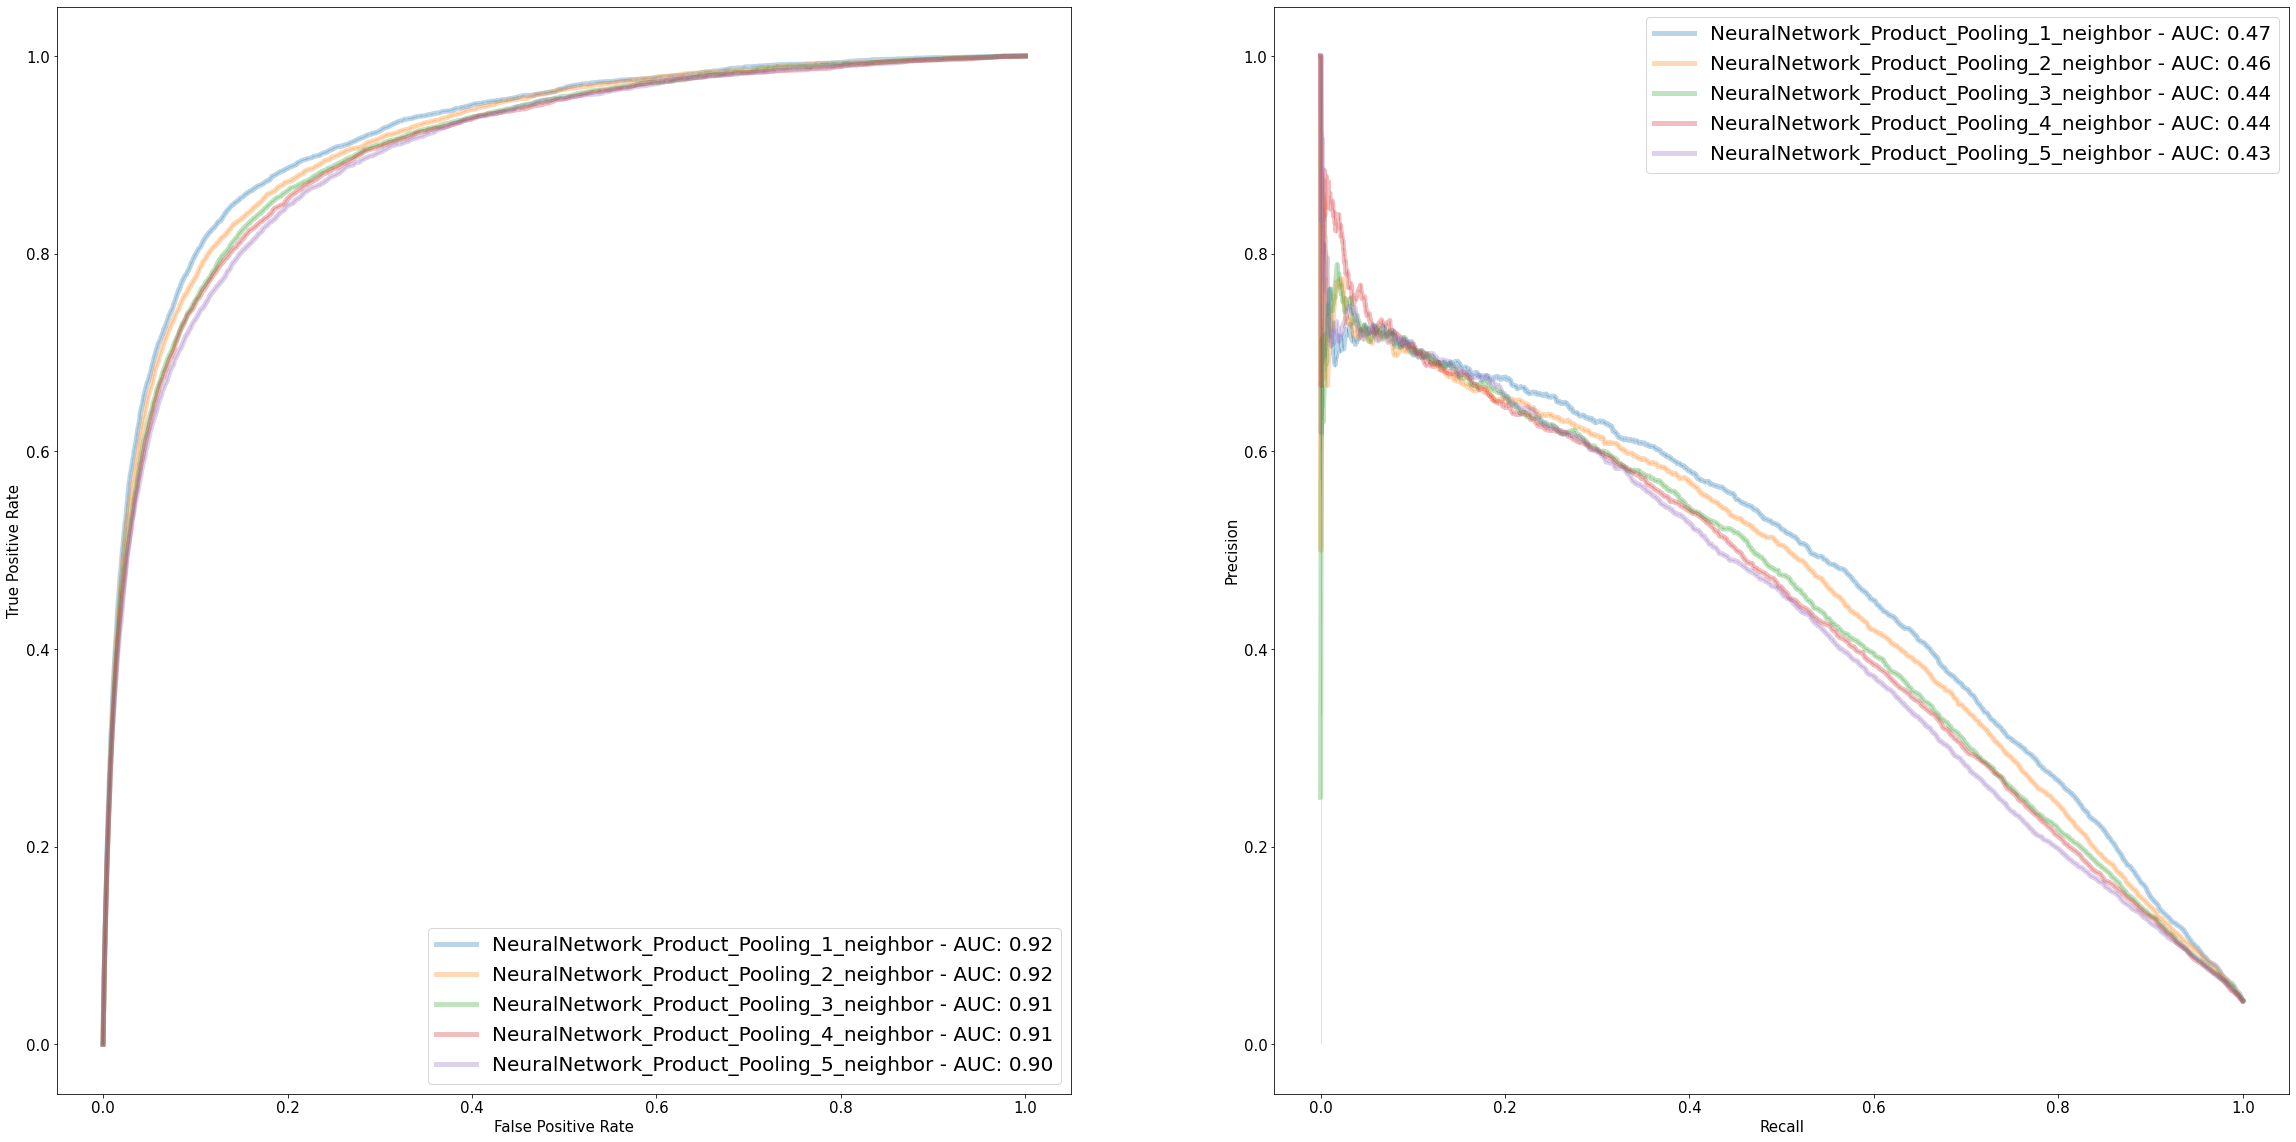

In [9]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
models = ['prod_pooling_{}_neighbor'.format(i) for i in range(1, 6, 1)]
df = []
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        label = "NeuralNetwork_Product_Pooling_{}_neighbor".format(model.split("_")[-2])
        print(label)
        plot_roc_curve(y_true, y_pred, label, axes[0])
        plot_pr_curve(y_true, y_pred, label, axes[1])
customise_roc_pr_plots(axes)

In [8]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
model_type = "prod_pooling"
models = ['prod_pooling_regularized_{}_neighbor'.format(i) for i in range(1, 6, 1)]
df = []
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
12,prod_pooling_regularized_5_neighbor,0.870,0.903,0.428,avg_loss
13,prod_pooling_regularized_5_neighbor,0.874,0.904,0.430,roc_auc
14,prod_pooling_regularized_5_neighbor,0.879,0.903,0.430,pr_auc
8,prod_pooling_regularized_3_neighbor,0.877,0.908,0.444,pr_auc
7,prod_pooling_regularized_3_neighbor,0.878,0.910,0.446,roc_auc
6,prod_pooling_regularized_3_neighbor,0.865,0.908,0.447,avg_loss
9,prod_pooling_regularized_4_neighbor,0.872,0.908,0.447,avg_loss
11,prod_pooling_regularized_4_neighbor,0.873,0.908,0.448,pr_auc
10,prod_pooling_regularized_4_neighbor,0.874,0.909,0.448,roc_auc
3,prod_pooling_regularized_2_neighbor,0.874,0.915,0.456,avg_loss


In [12]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
models = ["prod_pooling_attention_{}_neighbor".format(i) for i in range(6)]
df = []
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
9,prod_pooling_attention_3_neighbor,0.878,0.868,0.338,avg_loss
12,prod_pooling_attention_4_neighbor,0.902,0.871,0.350,avg_loss
15,prod_pooling_attention_5_neighbor,0.909,0.877,0.350,avg_loss
16,prod_pooling_attention_5_neighbor,0.874,0.881,0.356,roc_auc
6,prod_pooling_attention_2_neighbor,0.900,0.893,0.384,avg_loss
3,prod_pooling_attention_1_neighbor,0.898,0.902,0.386,avg_loss
13,prod_pooling_attention_4_neighbor,0.901,0.884,0.392,roc_auc
0,prod_pooling_attention_0_neighbor,0.886,0.896,0.398,avg_loss
17,prod_pooling_attention_5_neighbor,0.869,0.871,0.402,pr_auc
10,prod_pooling_attention_3_neighbor,0.902,0.890,0.409,roc_auc


NeuralNetwork_Product_Pooling_Attetion_1_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_Attetion_2_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_Attetion_3_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_Attetion_4_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


NeuralNetwork_Product_Pooling_Attetion_5_neighbor


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


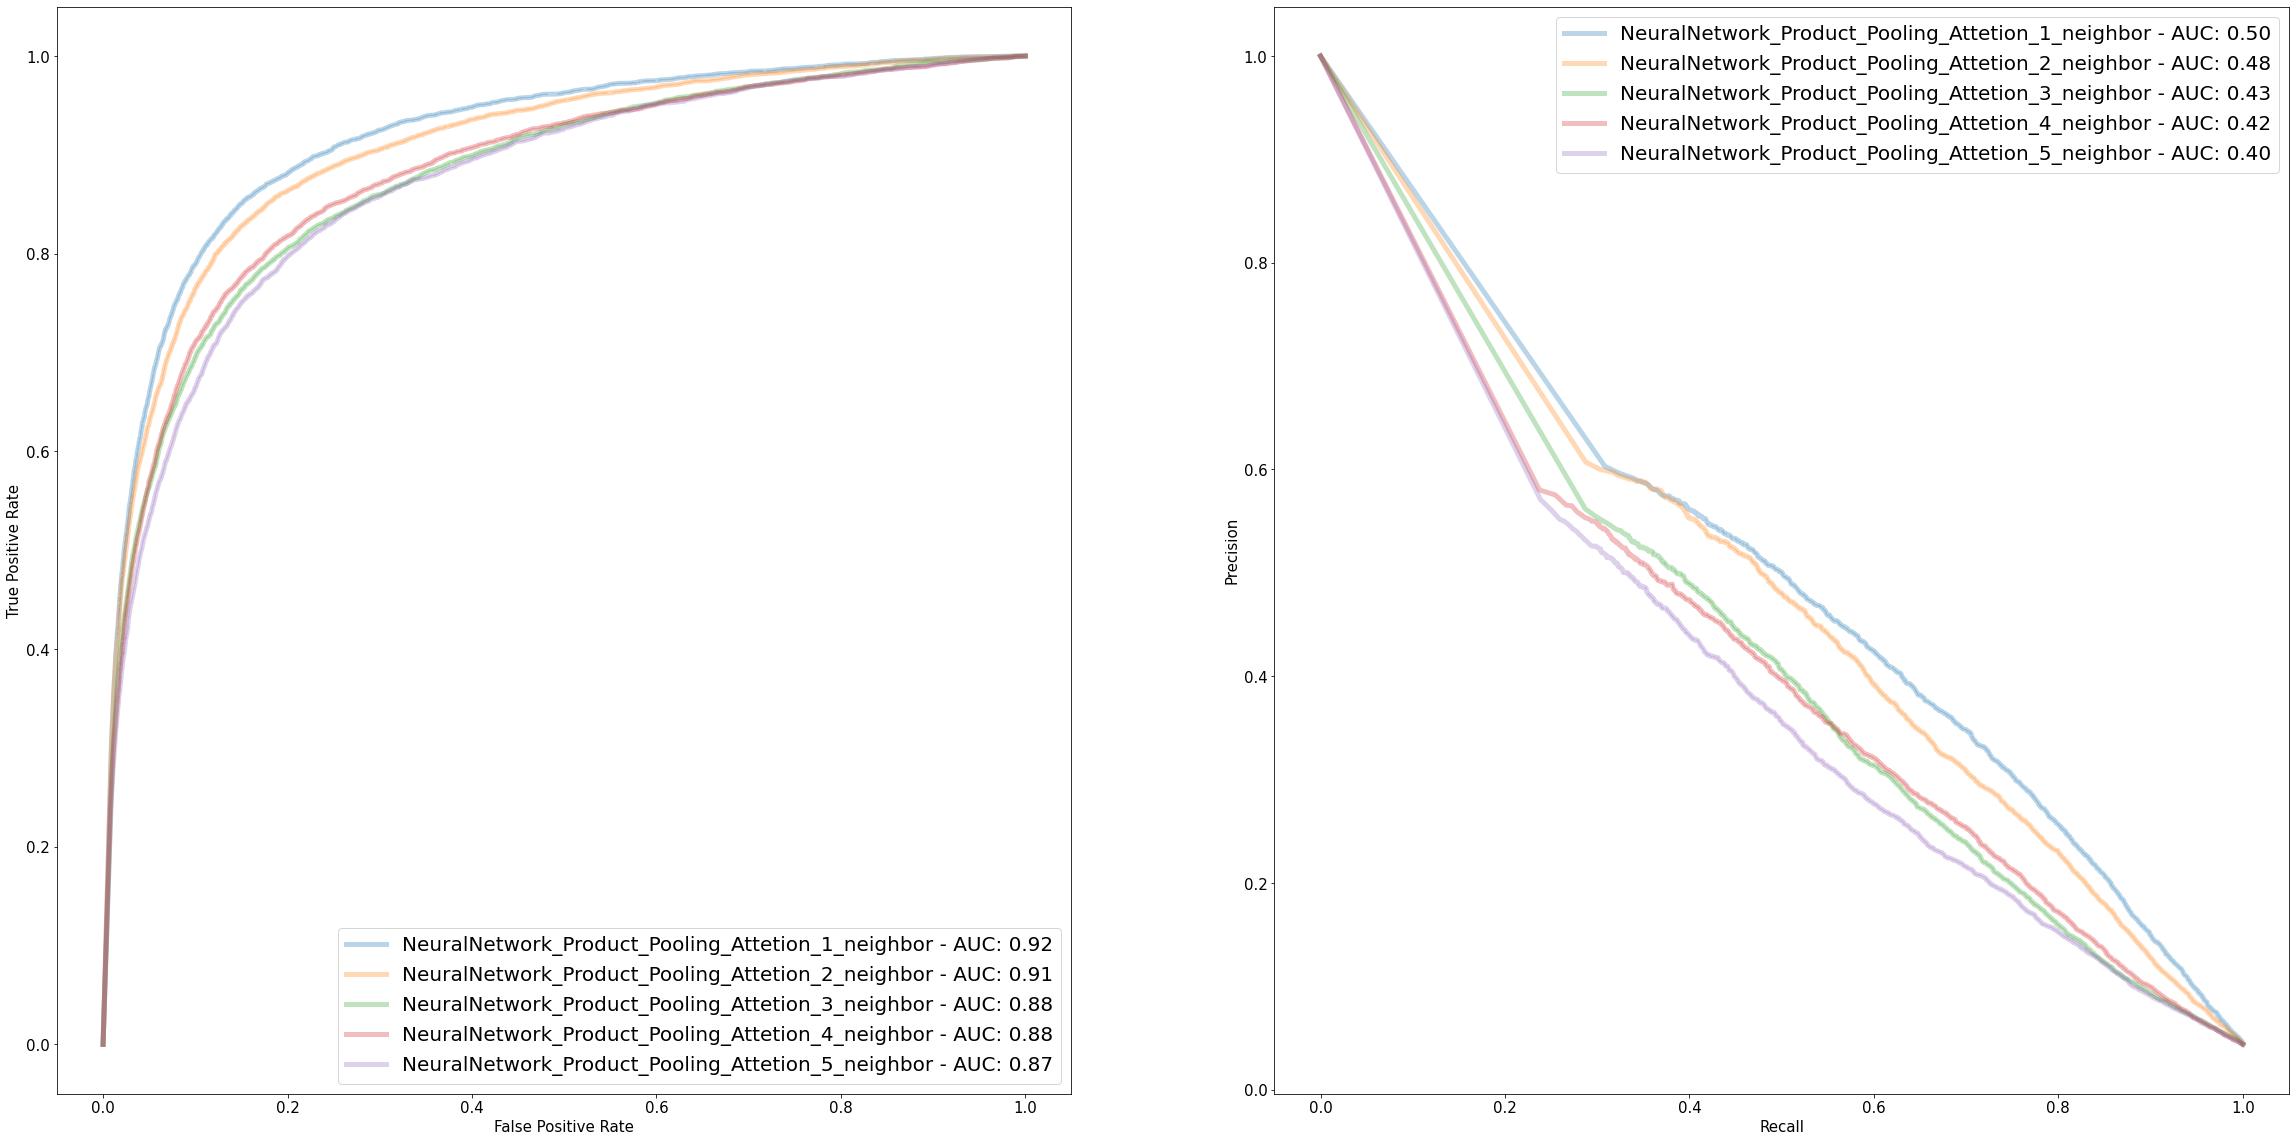

In [11]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
all_models = os.listdir(hct116_results)
models = ['prod_pooling_attention_{}_neighbor'.format(i) for i in range(1, 6, 1)]
df = []
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
for model in models:
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["pr_auc"]:
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            y_true_fold, y_pred_fold = np.array(result["y_true"]), np.mean(np.array(result["y_pred"]), axis=0)
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        label = "NeuralNetwork_Product_Pooling_Attetion_{}_neighbor".format(model.split("_")[-2])
        print(label)
        plot_roc_curve(y_true, y_pred, label, axes[0])
        plot_pr_curve(y_true, y_pred, label, axes[1])
customise_roc_pr_plots(axes)

Next we see the results on genomic level

In [7]:
import toml
from copy import deepcopy
from m6anet.utils.builder import build_dataloader

In [8]:
hct116_results = "/data03/christopher/m6anet_new_dataprep_results_cv/"
cv_dir = "/home/christopher/hct116_cv/"

configs = ["../m6anet/model/configs/training_configs/m6a_classification_nanopolish/0_neighbor/oversampled_summary_stats.toml",
           "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/1_neighbor/oversampled_summary_stats.toml",
           "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/2_neighbor/oversampled_summary_stats.toml",
           "../m6anet/model/configs/training_configs/m6a_classification_nanopolish/1_neighbor/oversampled_regularized.toml"
           ]
df = []
for model in os.listdir(hct116_results):
    num_neighbors = int(model.split("_")[-2])
    if num_neighbors == 0:
        train_config = toml.load(configs[0])
    elif num_neighbors == 2:
        train_config = toml.load(configs[2])
    else:
        model_name = model.split("_")[0]
        if model_name == 'summary':
            train_config = toml.load(configs[1])
        elif model_name == 'prod':
            train_config = toml.load(configs[-1])
        else:
            raise ValueError()
            
    model_dir = os.path.join(hct116_results, model)
    for selection_criterion in ["avg_loss", "roc_auc", "pr_auc"]:
        train_config_copy = deepcopy(train_config)
        y_true = []
        y_pred = []
        for fold_num in folds:
            fold_dir = os.path.join(model_dir, fold_num)
            result = joblib.load(os.path.join(fold_dir, "val_results_{}.joblib".format(selection_criterion)))
            
            train_config_copy["dataset"]["site_info"] = os.path.join(cv_dir, fold_num)
            train_config_copy["dataset"]["norm_path"] = os.path.join(cv_dir, fold_num, "norm_dict.joblib")
            
            _, _, val_dl = build_dataloader(train_config_copy, 25, verbose=False)
            
            cv_df = val_dl.dataset.data_info
            
            y_true_fold, y_pred_fold = result["y_true"], np.mean(np.array(result["y_pred"]), axis=0)
            
            assert(np.all(y_true_fold == cv_df["modification_status"]))
            
            cv_df["y_pred"] = y_pred_fold
            cv_df = cv_df.groupby(["gene_id", "genomic_position"]).mean()
            y_true_fold = cv_df["modification_status"].values
            y_pred_fold = cv_df["y_pred"].values
            
            y_true.append(y_true_fold)
            y_pred.append(y_pred_fold)
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, selection_criterion])
hct116_results = pd.DataFrame(df, columns=cols)
hct116_results.sort_values("PR AUC")

,Model Name,Accuracy,ROC AUC,PR AUC,Criteria
3,prod_pooling_attention_1_neighbor,0.896,0.910,0.389,avg_loss
6,prod_pooling_summary_stats_1_neighbor,0.921,0.903,0.417,avg_loss
9,summary_stats_nn_2_neighbor,0.944,0.898,0.419,avg_loss
13,summary_stats_nn_0_neighbor,0.857,0.907,0.434,roc_auc
7,prod_pooling_summary_stats_1_neighbor,0.892,0.924,0.436,roc_auc
12,summary_stats_nn_0_neighbor,0.893,0.908,0.437,avg_loss
0,summary_stats_nn_1_neighbor,0.931,0.912,0.441,avg_loss
14,summary_stats_nn_0_neighbor,0.860,0.907,0.442,pr_auc
10,summary_stats_nn_2_neighbor,0.890,0.915,0.447,roc_auc
11,summary_stats_nn_2_neighbor,0.893,0.915,0.453,pr_auc


It is not clear if the attention model is better than the summary stats model given that it is just slightly lower in terms of PR AUC but higher in accuracy. We next check the trained model performance on HEK293T cell lines where we have KO data

In [13]:
from statsmodels.stats.multitest import multipletests

/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will resul

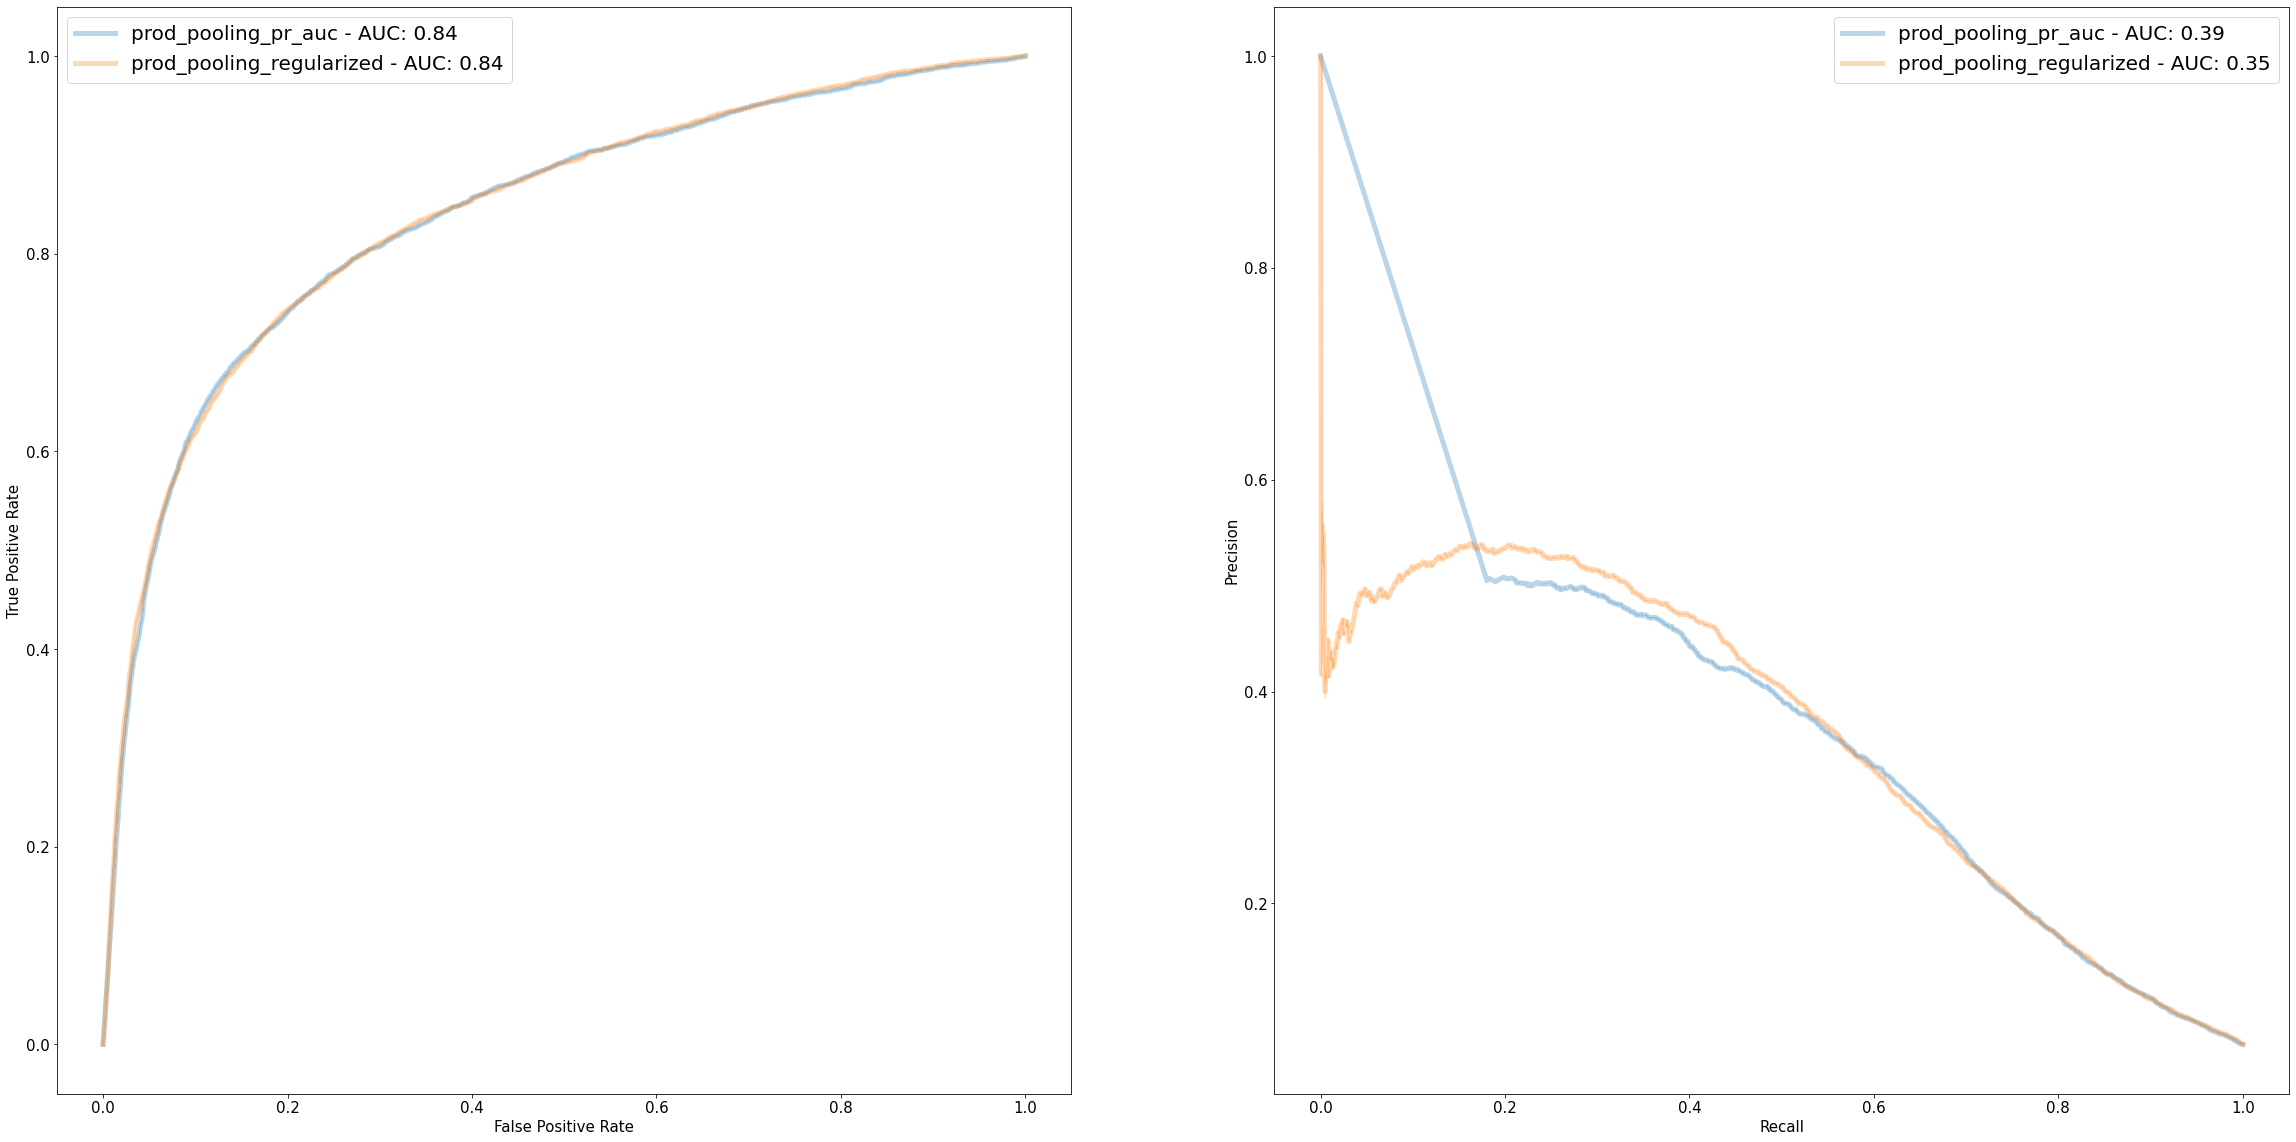

In [17]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []
save_per_epoch = 1
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
fig, axes = plt.subplots(1, 2, figsize=(40, 20))


for model in ['prod_pooling_pr_auc', 'prod_pooling_regularized']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))
        result = pd.merge(result, label, on=["gene_id", "genomic_position",
                                             "transcript_id", "transcript_position"])
        result = result.groupby(["gene_id", "genomic_position"]).mean()
        y_true, y_pred = np.array(result["modification_status"]), np.array(result["probability_modified"])
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        
        plot_roc_curve(y_true, y_pred, model, axes[0])
        plot_pr_curve(y_true, y_pred, model, axes[1])
        
        # Calculating KO sensitivity
#         result = pd.merge(result, ko_table, on=["gene_id", "genomic_position"])
#         result["pvalue"] = multipletests(result.pvalue, alpha=alpha, method='fdr_bh')[1]
#         ko_sensitivity = (result["pvalue"] < alpha) * 1
        
#         y_true = (result["modification_status"].values) | (ko_sensitivity.values)
#         y_pred = np.array(result["probability_modified"])
        
#         adjusted_acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
#         adjusted_roc_auc, adjusted_pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
#         df.append([model, acc, roc_auc, pr_auc, adjusted_acc, adjusted_roc_auc, adjusted_pr_auc, ])
# df = pd.DataFrame(df, columns=["Model Name", "Accuracy", "ROC AUC", "PR AUC", "Adjusted Accuracy",
#                                "Adjusted ROC AUC", "Adjusted PR AUC"])
# df
customise_roc_pr_plots(axes)

In [7]:
from itertools import product

CENTER_MOTIFS = [['A', 'G', 'T'], ['G', 'A'], ['A'], ['C'], ['A', 'C', 'T']]
ALL_KMERS = list(["".join(x) for x in product(*(CENTER_MOTIFS ))])

In [8]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []
save_per_epoch = 1
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005

df = None
for model in ['prod_pooling_pr_auc', 'prod_pooling_regularized']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))
        result = pd.merge(result, label, on=["gene_id", "genomic_position",
                                             "transcript_id", "transcript_position"])
        result = result[["gene_id", "genomic_position", "transcript_id", "transcript_position", 
                        "probability_modified", "modification_status"]]

        result = result.rename({'probability_modified': "probability_modified_{}".format(model)}, axis=1)
        if df is None:
            df = result
        else:
            df = df.merge(result, on=["transcript_id", "transcript_position"])

epinano_dir = "/data03/christopher/epinano_svm_results"
for model in os.listdir(epinano_dir):
    model_name = model.split(".csv")[0]
    epinano_df = pd.read_csv(os.path.join(epinano_dir, model),
                             usecols=["#Kmer", "Window", "Ref", "ProbM"])
    epinano_df = epinano_df.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id'}, axis=1)
    epinano_df["transcript_position"] = epinano_df["transcript_position"].apply(lambda x: int(x.split(":")[1]))
    epinano_df["transcript_id"] = epinano_df["transcript_id"].apply(lambda x: x.split(".")[0])
    epinano_df = epinano_df.rename({'#Kmer': 'kmer', 'Window': 'transcript_position', 'Ref': 'transcript_id',
                                    'ProbM': "probability_modified_{}".format(model_name)}, axis=1)
    epinano_df = epinano_df[epinano_df["kmer"].isin(ALL_KMERS)].reset_index(drop=True)
    epinano_df = epinano_df[["transcript_id", "transcript_position", "probability_modified_{}".format(model_name)]]
    df = df.merge(epinano_df, on=["transcript_id", "transcript_position"])
    
df = df.rename({'probability_modified_prod_pooling_pr_auc': 'probability_modified_prod_pooling_attention',
           'probability_modified_prod_pooling_regularized': 'probability_modified_prod_pooling'}, axis=1)

df = df.rename({'gene_id_x': 'gene_id',
                'genomic_position_x': 'genomic_position',
                'modification_status_x': 'modification_status'}, axis=1)

prod_pooling_attention


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


prod_pooling


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM20_model1


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM20_model2


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM100_model2


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM100_model1


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


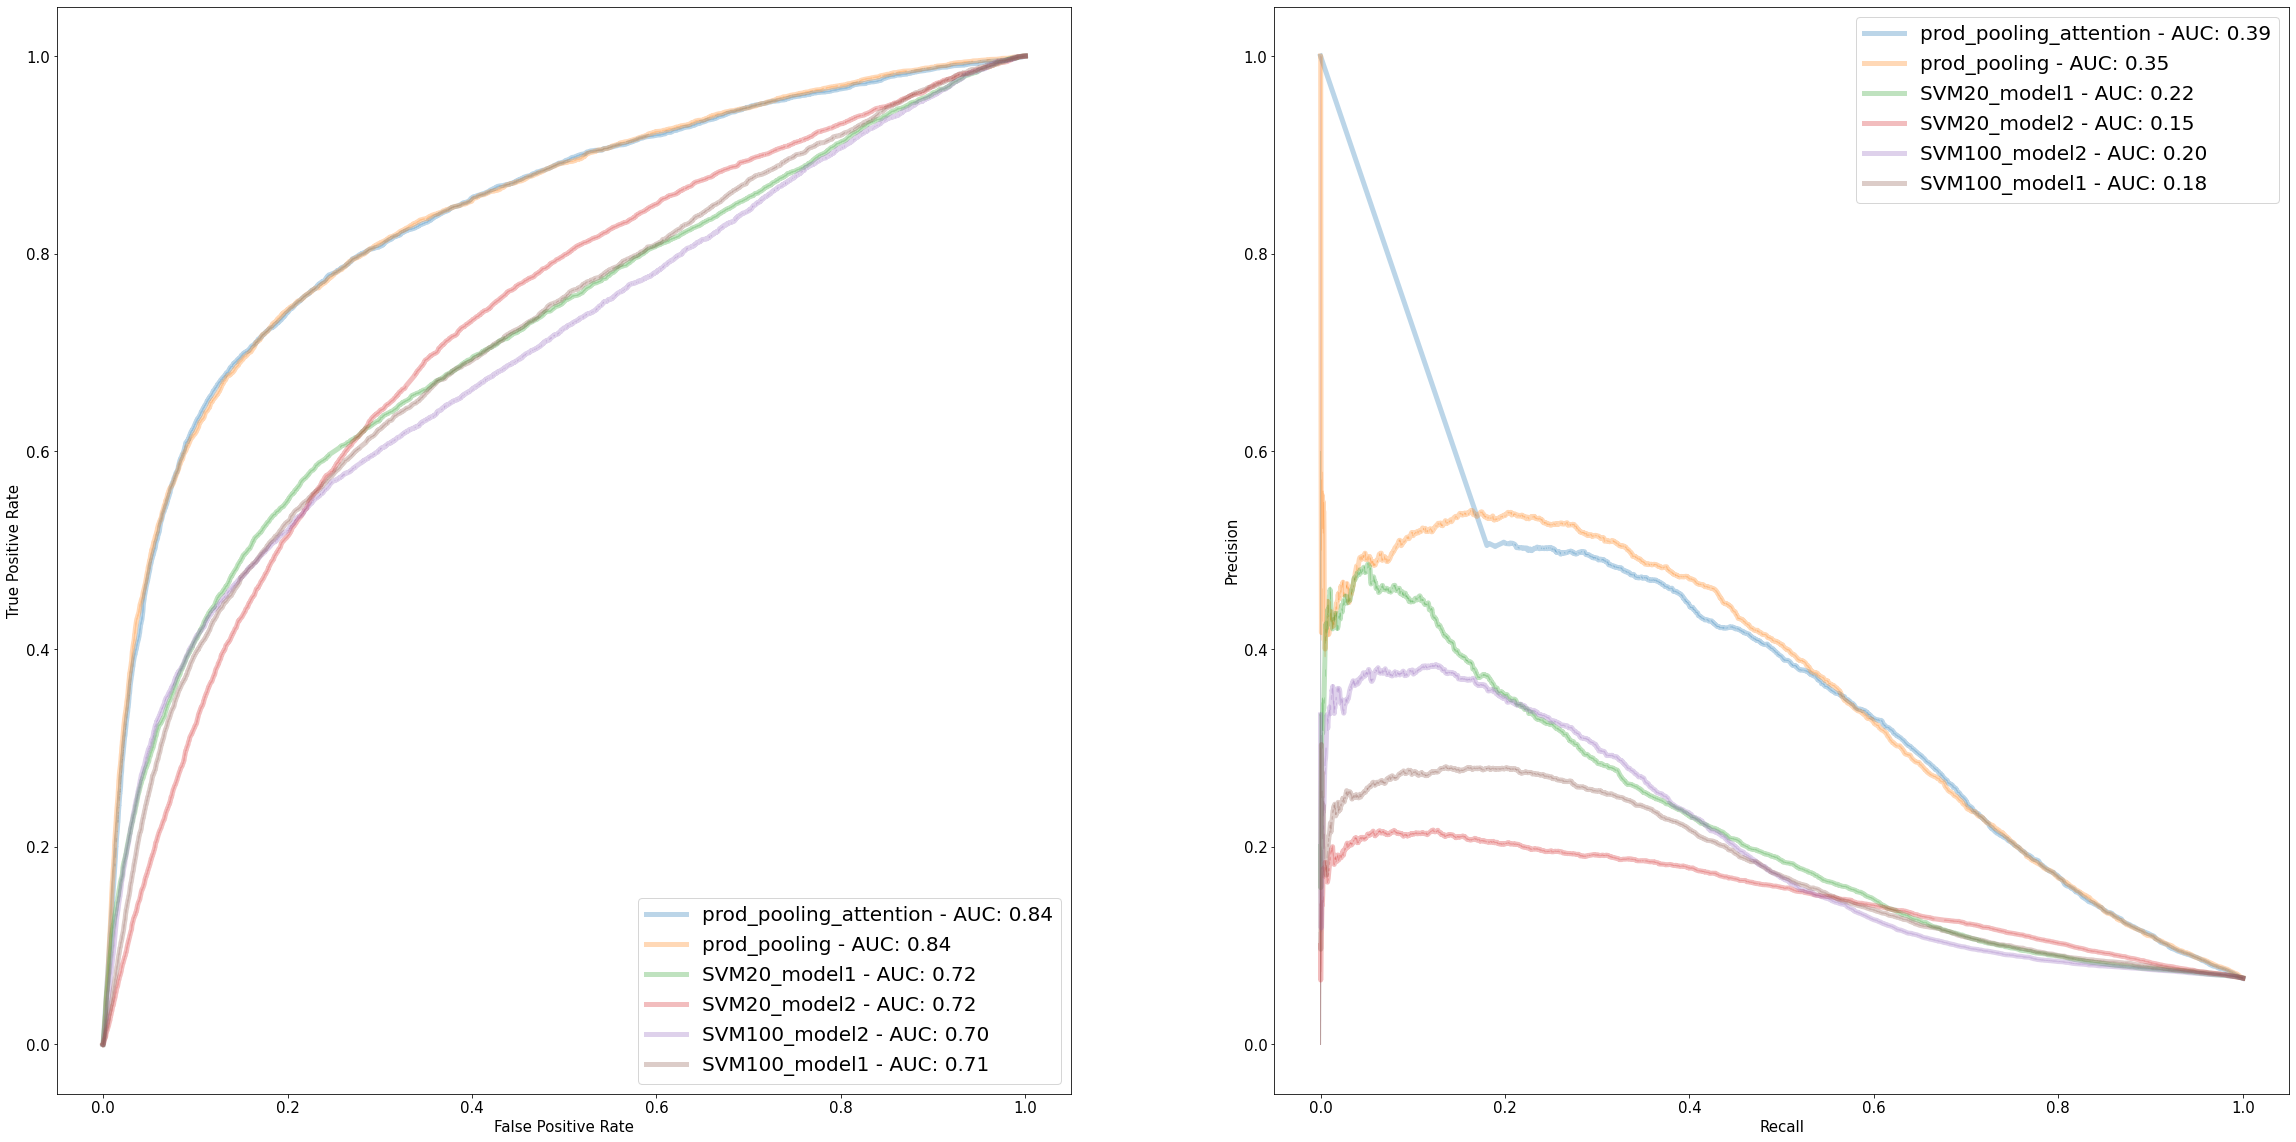

In [82]:
proba_cols = [x for x in df.columns if "probability_modified" in x]
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
to_plot = df.groupby(["gene_id", "genomic_position"]).mean().reset_index()
for col in proba_cols:
    y_true, y_pred = np.array(to_plot["modification_status"]), np.array(to_plot[col])
    model_name = col.split("probability_modified_")[-1]
    print(model_name)
    plot_roc_curve(y_true, y_pred, model_name, axes[0])
    plot_pr_curve(y_true, y_pred, model_name, axes[1])
customise_roc_pr_plots(axes)

prod_pooling_attention


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


prod_pooling


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM20_model1


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM20_model2


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM100_model2


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


SVM100_model1


/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/data03/christopher/miniconda3/envs/clr/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


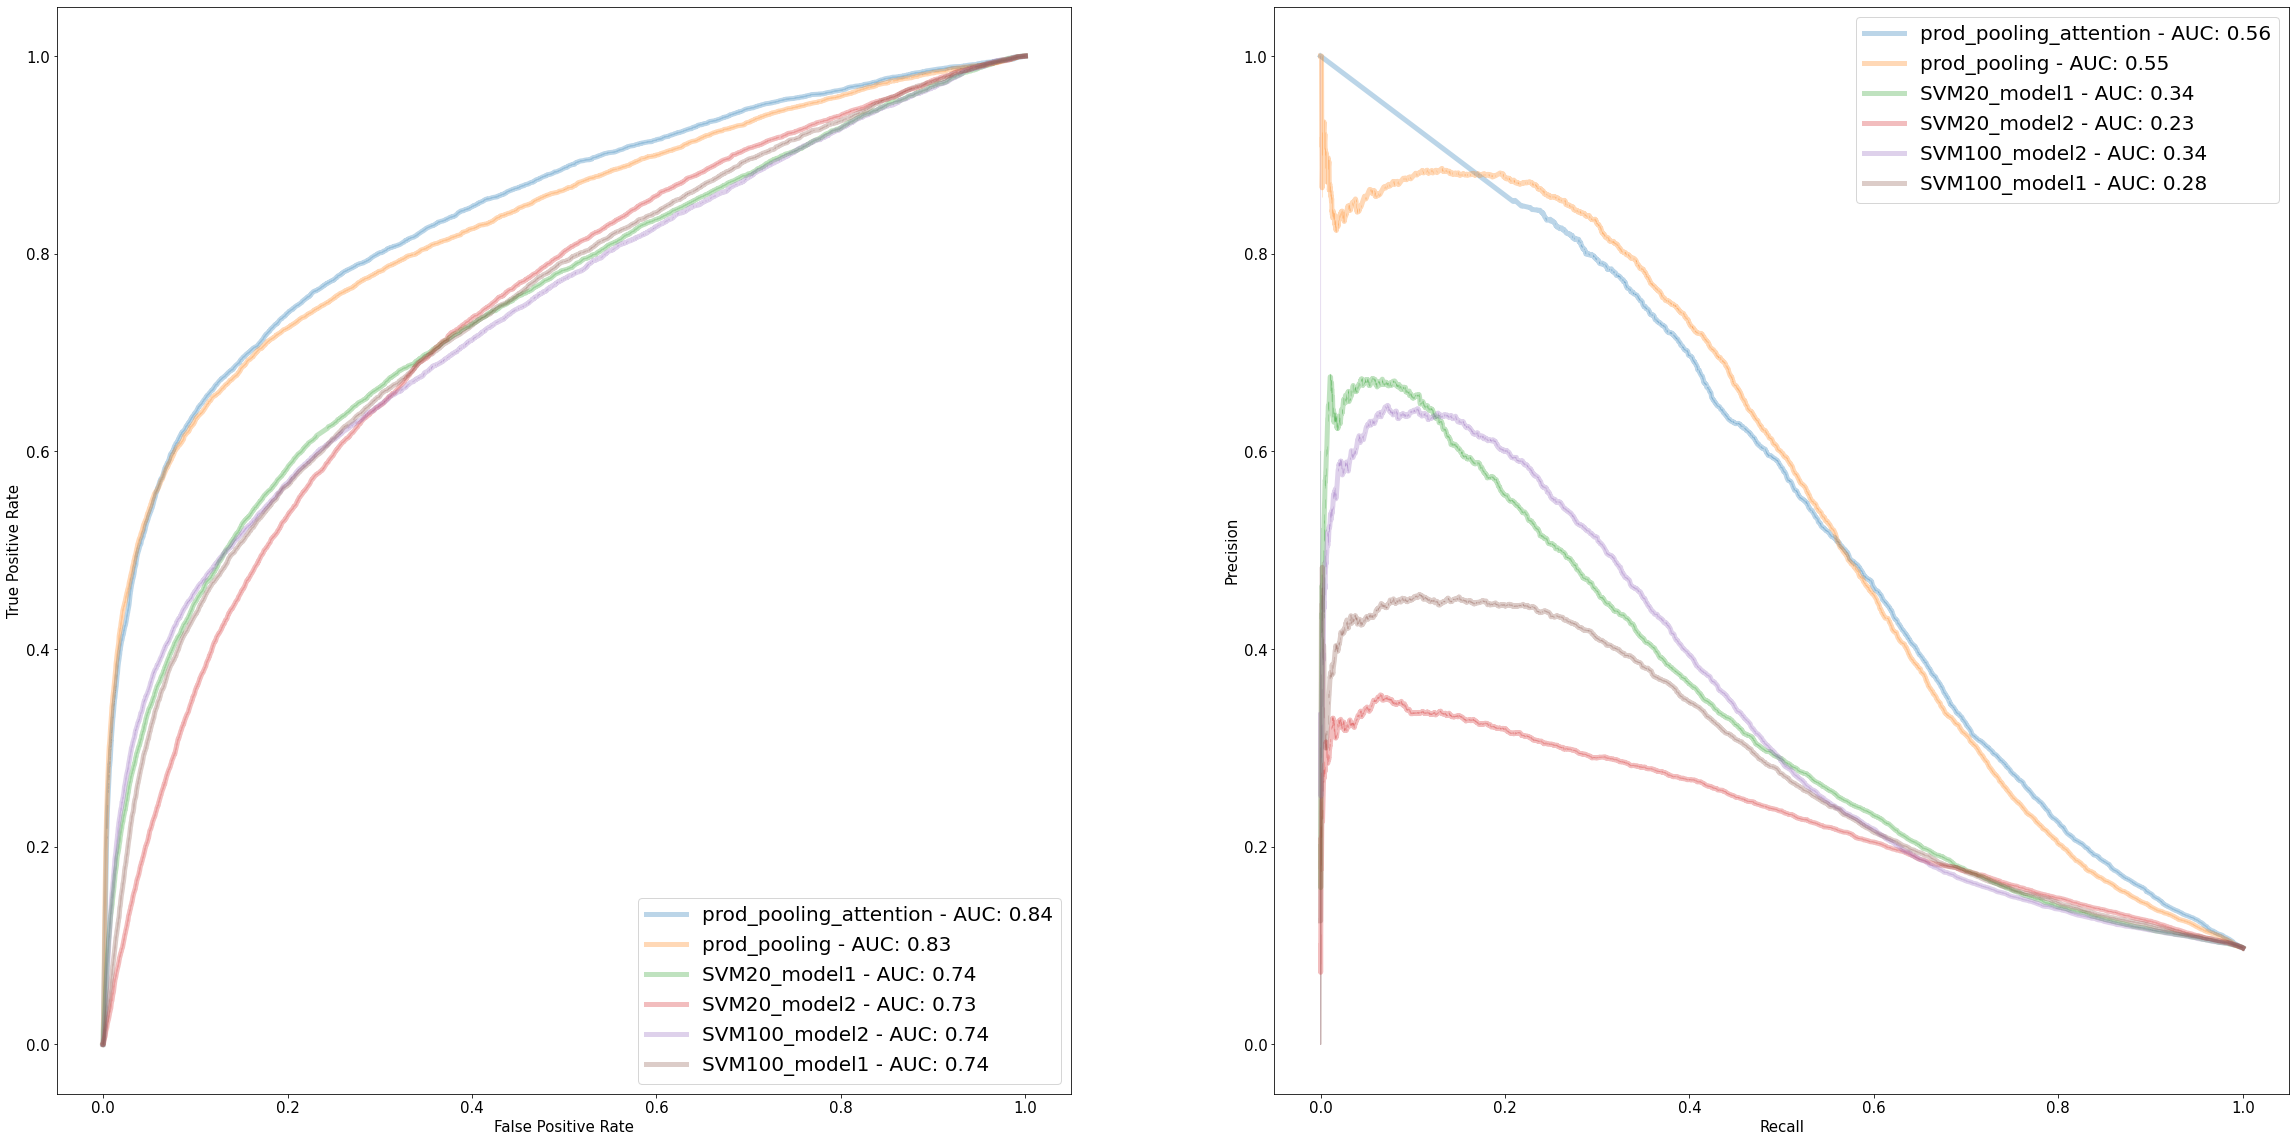

In [94]:
proba_cols = [x for x in df.columns if "probability_modified" in x]
fig, axes = plt.subplots(1, 2, figsize=(40, 20))
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
ko_table["pvalue"] = multipletests(ko_table.pvalue, alpha=alpha, method='fdr_bh')[1]

to_plot = df.groupby(["gene_id", "genomic_position"]).mean().reset_index()
to_plot = pd.merge(to_plot, ko_table, on=["gene_id", "genomic_position"])

alpha = 0.005

for col in proba_cols:
    y_true, y_pred = np.array(to_plot["modification_status"]), np.array(to_plot[col])
    model_name = col.split("probability_modified_")[-1]
    print(model_name)
    
    ko_sensitivity = (to_plot["pvalue"] < alpha) * 1
        
    y_true = (to_plot["modification_status"].values.astype('int')) | (ko_sensitivity.values)
    y_pred = np.array(to_plot[col])
        
    plot_roc_curve(y_true, y_pred, model_name, axes[0])
    plot_pr_curve(y_true, y_pred, model_name, axes[1])
customise_roc_pr_plots(axes)

In [9]:
from pyensembl import Genome
from tqdm.notebook import tqdm

def get_y(info_df, table, col_name):
    g, chrsm = info_df["genomic_position"].values, info_df["chr"].values
    info_df[col_name] = np.array([1 if (g_pos, chr_id) in table.index else 0
                                               for g_pos, chr_id in tqdm(zip(g, chrsm), total=len(g),
                                               desc="Getting label information")]) 
    return info_df

def add_chromosome_and_gene_info(info_df):
    info_df["chr"] = info_df["transcript_id"].apply(lambda x: chr_map[genome.transcript_by_id(x).contig])
    return info_df

chrsm_annot_dir = "/data03/christopher/annotations/chrsm_annot.txt"
genome = Genome(reference_name='GRCh38',
            annotation_name='my_genome_features',
            gtf_path_or_url='/data03/christopher/annotations/Homo_sapiens.GRCh38.91.chr_patch_hapl_scaff.gtf',
            transcript_fasta_paths_or_urls='/data03/christopher/annotations/Homo_sapiens.GRCh38.cdna.ncrna.fa') 
chr_map = {}
with open(chrsm_annot_dir) as f:
    for line in f:
        ensembl, ucsc = line.strip("\n").split("\t")
        chr_map[ensembl] = ucsc

m6ace = pd.read_csv("/data03/christopher/annotations/m6ACE_HEK293T.csv.gz").set_index(["End", "Chr"])
miclip = pd.read_csv("/data03/christopher/annotations/miclip_HEK293T.csv.gz").set_index(["End", "Chr"])

df = add_chromosome_and_gene_info(df)
df = get_y(df, m6ace, "m6ACE")
df = get_y(df, miclip, "miCLIP")

Getting label information:   0%|          | 0/94932 [00:00<?, ?it/s]

Getting label information:   0%|          | 0/94932 [00:00<?, ?it/s]

/data03/christopher/miniconda3/envs/m6anet/lib/python3.8/site-packages/IPython/core/interactiveshell.py:2940: PerformanceWarning: indexing past lexsort depth may impact performance.
  return runner(coro)


In [20]:
from matplotlib_venn import venn3

def get_ko_sensitivity(coords, wt_ko_table):
    sensitivity = np.array([wt_ko_table[(coord[0], int(coord[1]))] 
                            for coord in coords if coord in wt_ko_table])
    sensitivity_filtered = sensitivity < 0.05
    return round(np.sum(sensitivity_filtered) / len(sensitivity_filtered), 2)

def generate_venn(df, col, threshold, wt_ko_table, axes):    
    m6ace_drach = df[df["m6ACE"] == 1]
    miclip_drach = df[df["miCLIP"] == 1]
    pred_df_positive = df[df["probability_modified_{}".format(col)] >= threshold]
    
    m6ace_coords = set((x, int(y)) for x, y in m6ace_drach[["chr", "genomic_position"]].values)
    miclip_coords = set((x, int(y)) for x, y in miclip_drach[["chr", "genomic_position"]].values if (x==x and y==y))
    m6anet_coords = set((x, int(y)) for x, y in pred_df_positive[["chr", "genomic_position"]].values)

    m6ace_miclip = set([x for x in m6ace_coords.intersection(miclip_coords) if x not in 
                             m6anet_coords])
    m6ace_m6anet = set([x for x in m6ace_coords.intersection(m6anet_coords) if x not in 
                             miclip_coords])
    m6anet_miclip = set([x for x in m6anet_coords.intersection(miclip_coords) if x not in 
                              m6ace_coords])
    all_intersections = m6ace_coords.intersection(miclip_coords).intersection(m6anet_coords)

    m6ace_only = set([coord for coord in m6ace_coords if ((coord not in m6ace_m6anet) and (coord not in m6ace_miclip)
                                                          and (coord not in all_intersections))])
    miclip_only = set([coord for coord in miclip_coords if ((coord not in m6ace_miclip) and (coord not in m6anet_miclip)
                                                          and (coord not in all_intersections))])
    m6anet_only = set([coord for coord in m6anet_coords if ((coord not in m6ace_m6anet) and (coord not in m6anet_miclip)
                                                          and (coord not in all_intersections))])

    out1 = venn3(subsets=(len(m6ace_only),
                          len(miclip_only),
                          len(m6ace_miclip),
                          len(m6anet_only),
                          len(m6ace_m6anet), len(m6anet_miclip), len(all_intersections)),
                 set_labels = ('m6ACE', 'miCLIP', 'm6ANet'), alpha = 0.5, ax=axes[0])

    out2 = venn3(subsets=(get_ko_sensitivity(m6ace_only, wt_ko_table),
                          get_ko_sensitivity(miclip_only, wt_ko_table),
                          get_ko_sensitivity(m6ace_miclip, wt_ko_table),
                          get_ko_sensitivity(m6anet_only, wt_ko_table),
                          get_ko_sensitivity(m6ace_m6anet, wt_ko_table),
                          get_ko_sensitivity(m6anet_miclip, wt_ko_table),
                          get_ko_sensitivity(all_intersections, wt_ko_table)),
                 set_labels = ('m6ACE', 'miCLIP', 'm6ANet'), alpha = 0.5, ax=axes[1])
    for out in [out1, out2]:
        for text in out.set_labels:
            text.set_fontsize(25)
        for text in out.subset_labels:
            text.set_fontsize(25)
    axes[0].set_title("Predictive threshold: {}".format(threshold), fontdict={'fontsize': 25})
    axes[1].set_title("Knockout sensitivity", fontdict={'fontsize': 25})

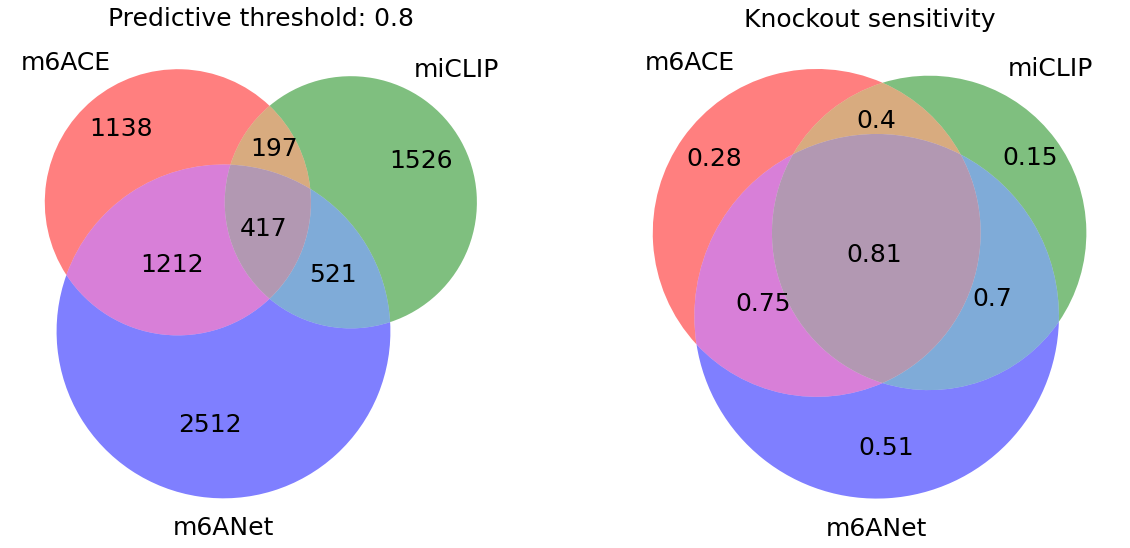

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 20))
wt_ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
wt_ko_table["padj"] = multipletests(wt_ko_table.pvalue, alpha=0.05, method='fdr_bh')[1]
wt_ko_table["chr"] = wt_ko_table["gene_id"].apply(lambda x: chr_map[genome.gene_by_id(x).contig])
wt_ko_table = wt_ko_table.set_index(["chr", "genomic_position"])
wt_ko_table = wt_ko_table["padj"].to_dict()
generate_venn(df, "prod_pooling", 0.8, wt_ko_table, axes)

In [23]:
generate_venn(df, "prod_pooling", 0.5, wt_ko_table, axes)

In [100]:
m6ace

,,Start,Strand,WT-RML1,WT-RML2,WT-RML3,KO-RML1,KO-RML2,KO-RML3,Gene,Type,Motif,padj-WT,padj-KO,WT-RML-avg,KO-RML-avg,WT-KO,pval
End,Chr,,,,,,,,,,,,,,,,,
136874123,chrX,136874122,-,1.111,1.306,0.939,0.157,0.145,0.068,RBMX,3utr,GGACC,7.370e-12,NaN,1.119,0.123,9.086,4.059e-04
21596202,chr6,21596201,+,5.264,9.538,3.860,0.801,1.026,0.658,SOX4,3utr,GGACG,2.690e-06,0.041,6.220,0.828,7.509,1.723e-02
138164817,chr5,138164816,-,1.742,1.270,0.891,0.104,0.168,0.106,BRD8,cds,GGACT,7.330e-03,NaN,1.301,0.126,10.323,4.466e-03
130135164,chr9,130135163,+,3.461,1.185,1.810,0.112,0.402,0.265,GPR107,3utr,TAACT,3.080e-02,NaN,2.152,0.260,8.277,2.529e-02
35455984,chr6,35455983,+,4.317,5.767,2.573,0.487,0.391,0.796,FANCE,cds,AGACA,1.720e-05,NaN,4.219,0.558,7.561,8.547e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43224173,chr2,43224172,-,4.396,2.884,6.334,0.498,0.503,0.557,ZFP36L2,3utr,GGACT,1.089e-03,NaN,4.538,0.519,8.738,7.906e-03
84784021,chr15,84784020,+,3.517,1.553,4.354,0.301,0.279,0.398,ZNF592,cds,GGACG,4.796e-02,NaN,3.141,0.326,9.635,1.380e-02
1699034,chr16,1699033,+,1.575,1.925,1.644,0.312,0.325,0.367,HN1L,3utr,AAACT,2.580e-05,0.027,1.715,0.335,5.123,1.095e-04


In [104]:
miclip["End"].astype('int')

KeyError: 'End'

In [30]:
pd.read_csv("/data03/christopher/gt_mapping_final/ENST00000354667/gt_mapping.csv.gz").iloc[206]

Unnamed: 0                206
tx_id         ENST00000354667
tx_pos                    206
g_id          ENSG00000122566
g_pos                26197835
chr                         7
kmer                    GAAAA
Name: 206, dtype: object

In [13]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []
save_per_epoch = 1
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
for model in ['prod_pooling_pr_auc', 'prod_pooling_roc_auc', 'prod_pooling_summary_stats_pr_auc',
              'prod_pooling_summary_stats_roc_auc']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))
        result = pd.merge(result, label, on=["transcript_id", "transcript_position"])
        y_true, y_pred = np.array(result["modification_status"]), np.array(result["probability_modified"])
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        
        # Calculating KO sensitivity
        result = pd.merge(result, ko_table, on=["gene_id", "genomic_position"])
        result["pvalue"] = multipletests(result.pvalue, alpha=alpha, method='fdr_bh')[1]
        ko_sensitivity = (result["pvalue"] < alpha) * 1
        
        y_true = (result["modification_status"].values) | (ko_sensitivity.values)
        y_pred = np.array(result["probability_modified"])
        
        adjusted_acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        adjusted_roc_auc, adjusted_pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, adjusted_acc, adjusted_roc_auc, adjusted_pr_auc, ])
df = pd.DataFrame(df, columns=["Model Name", "Accuracy", "ROC AUC", "PR AUC", "Adjusted Accuracy",
                               "Adjusted ROC AUC", "Adjusted PR AUC"])
df

,Model Name,Accuracy,ROC AUC,PR AUC,Adjusted Accuracy,Adjusted ROC AUC,Adjusted PR AUC
0,prod_pooling_pr_auc,0.897,0.818,0.392,0.883,0.780,0.512
1,prod_pooling_roc_auc,0.889,0.826,0.353,0.877,0.788,0.509
2,prod_pooling_summary_stats_pr_auc,0.795,0.817,0.405,0.792,0.772,0.496
3,prod_pooling_summary_stats_roc_auc,0.892,0.827,0.367,0.880,0.784,0.501


Let us evaluate this with genomic positions

In [14]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []
save_per_epoch = 1
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
for model in ['prod_pooling_pr_auc', 'prod_pooling_roc_auc', 'prod_pooling_summary_stats_pr_auc',
              'prod_pooling_summary_stats_roc_auc']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))
        result = pd.merge(result, label, on=["transcript_id", "transcript_position"])

        # Calculating KO sensitivity
        result = pd.merge(result, ko_table, on=["gene_id", "genomic_position"])
        result["pvalue"] = multipletests(result.pvalue, alpha=alpha, method='fdr_bh')[1]
        result = result.groupby(["gene_id", "genomic_position"]).mean()

        ko_sensitivity = (result["pvalue"] < alpha) * 1
        result["modification_status"] = result["modification_status"].astype('int')
        
        y_true, y_pred = np.array(result["modification_status"]), np.array(result["probability_modified"])
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        

        y_true = (result["modification_status"].values) | (ko_sensitivity.values)
        y_pred = np.array(result["probability_modified"])
        
        adjusted_acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        adjusted_roc_auc, adjusted_pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        df.append([model, acc, roc_auc, pr_auc, adjusted_acc, adjusted_roc_auc, adjusted_pr_auc, ])
df = pd.DataFrame(df, columns=["Model Name", "Accuracy", "ROC AUC", "PR AUC", "Adjusted Accuracy",
                               "Adjusted ROC AUC", "Adjusted PR AUC"])
df

,Model Name,Accuracy,ROC AUC,PR AUC,Adjusted Accuracy,Adjusted ROC AUC,Adjusted PR AUC
0,prod_pooling_pr_auc,0.897,0.837,0.393,0.899,0.837,0.561
1,prod_pooling_roc_auc,0.889,0.845,0.349,0.893,0.843,0.554
2,prod_pooling_summary_stats_pr_auc,0.795,0.831,0.407,0.803,0.824,0.539
3,prod_pooling_summary_stats_roc_auc,0.893,0.845,0.366,0.896,0.839,0.546


Let us plot the ROC curve and PR curve

In [95]:
def plot_roc_curve(y_true, y_pred, label, ax):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    sns.lineplot(fpr, tpr, lw=1, ax=ax, alpha=0.3, label="{} - AUC: %0.2f".format(label) % (roc_auc))


def plot_pr_curve(y_true, y_pred, label, ax):
    precision, recall, _ = precision_recall_curve(y_true, y_pred, pos_label=1)
    pr_auc = auc(recall, precision)
    sns.lineplot(recall, precision, lw=1, alpha=0.3, ax=ax, label="{} - AUC: %0.2f".format(label) % (pr_auc))
    
def customise_roc_pr_plots(axes, label_size=15, font_size=15, linewidth=5, patch_size=20):
    # Customizing plots
    for ax in axes:
        ax.xaxis.label.set_size(label_size)
        ax.yaxis.label.set_size(label_size)

        for axis in [ax.xaxis, ax.yaxis]:
            for tick in axis.get_major_ticks():
                tick.label.set_fontsize(font_size)

        plt.setp(ax.get_legend().get_texts(), fontsize='{}'.format(font_size))
        plt.setp(ax.lines, linewidth=linewidth)

    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')

    for ax in axes:
        for axis in [ax.xaxis, ax.yaxis]:
            axis.label.set_size(font_size)

    axes[1].set_xlabel('Recall')
    axes[1].set_ylabel('Precision')

    for ax in axes:
        ax.legend(loc='best', prop={'size': patch_size})

/home/christopher/miniconda3/envs/clr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/christopher/miniconda3/envs/clr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/christopher/miniconda3/envs/clr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

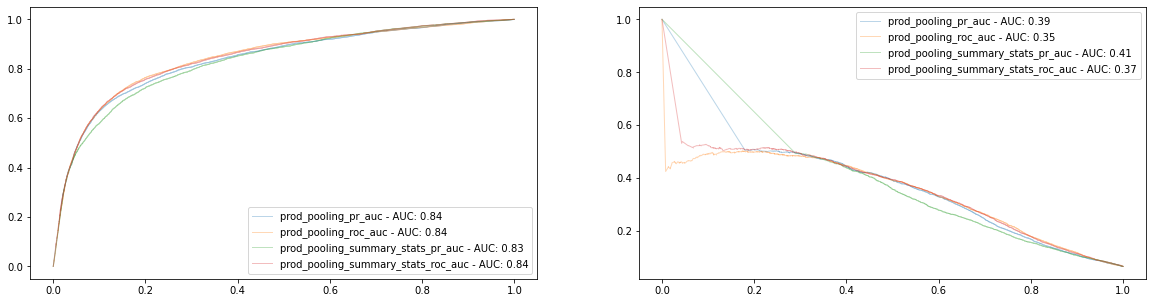

In [96]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []
save_per_epoch = 1
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
for model in ['prod_pooling_pr_auc', 'prod_pooling_roc_auc', 'prod_pooling_summary_stats_pr_auc',
              'prod_pooling_summary_stats_roc_auc']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))
        result = pd.merge(result, label, on=["transcript_id", "transcript_position"])

        # Calculating KO sensitivity
        result = pd.merge(result, ko_table, on=["gene_id", "genomic_position"])
        result["pvalue"] = multipletests(result.pvalue, alpha=alpha, method='fdr_bh')[1]
        result = result.groupby(["gene_id", "genomic_position"]).mean()
        y_true, y_pred = np.array(result["modification_status"]), np.array(result["probability_modified"])
        plot_roc_curve(y_true, y_pred, model, ax=axes[0])
        plot_pr_curve(y_true, y_pred, model, ax=axes[1])
        

/home/christopher/miniconda3/envs/clr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/christopher/miniconda3/envs/clr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/christopher/miniconda3/envs/clr/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an 

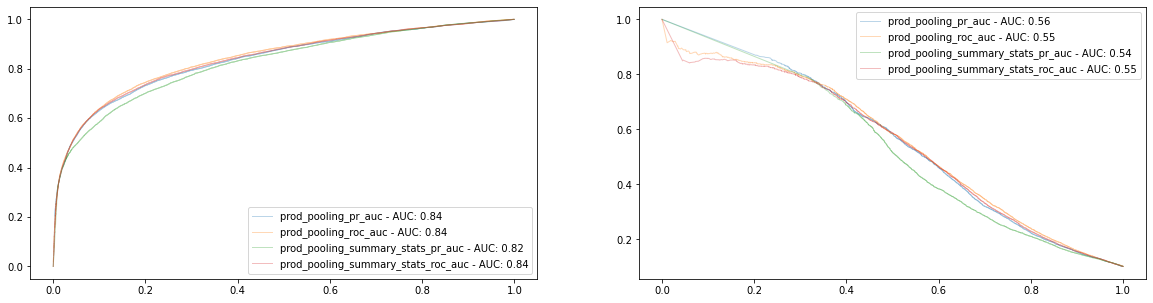

In [97]:
model_results = "/data03/christopher/m6anet_new_dataprep_hek293/GohGIS_Hek293T_directRNA_Rep2/"
df = []
save_per_epoch = 1
ko_table = pd.read_csv("/data03/christopher/wt_ko_hek293_ttest/ttest_results.csv.gz")
alpha = 0.005
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

for model in ['prod_pooling_pr_auc', 'prod_pooling_roc_auc', 'prod_pooling_summary_stats_pr_auc',
              'prod_pooling_summary_stats_roc_auc']:
        model_dir = os.path.join(model_results, model)
        result = pd.read_csv(os.path.join(model_dir, "data.result.csv"))
        label = pd.read_csv(os.path.join(model_results, "data.readcount.labelled"))
        result = pd.merge(result, label, on=["transcript_id", "transcript_position"])

        # Calculating KO sensitivity
        result = pd.merge(result, ko_table, on=["gene_id", "genomic_position"])
        result["pvalue"] = multipletests(result.pvalue, alpha=alpha, method='fdr_bh')[1]
        result = result.groupby(["gene_id", "genomic_position"]).mean()

        ko_sensitivity = (result["pvalue"] < alpha) * 1
        result["modification_status"] = result["modification_status"].astype('int')
        
        y_true, y_pred = np.array(result["modification_status"]), np.array(result["probability_modified"])
        acc = accuracy_score(y_true, (y_pred >= 0.5) * 1)
        roc_auc, pr_auc = compute_roc_auc(y_true, y_pred), compute_pr_auc(y_true, y_pred)
        

        y_true = (result["modification_status"].values) | (ko_sensitivity.values)
        y_pred = np.array(result["probability_modified"])
        
        plot_roc_curve(y_true, y_pred, model, ax=axes[0])
        plot_pr_curve(y_true, y_pred, model, ax=axes[1])

In [89]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

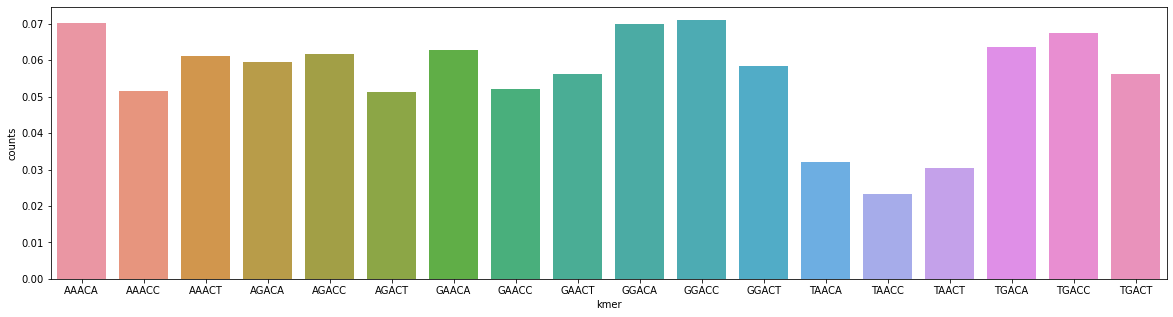

In [90]:
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
kmers, counts = np.unique(result["kmer"], return_counts=True)
counts = counts / np.sum(counts)
data = pd.DataFrame({'kmer': kmers, 'counts': counts})
data = pd.DataFrame(data, columns=["kmer", "counts"])
sns.barplot(x="kmer", y="counts", data=data, ax=ax)

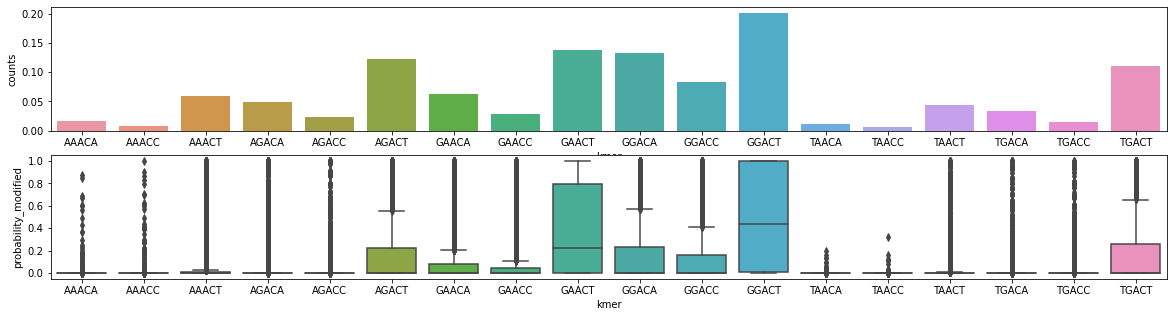

In [94]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5))
kmers, counts = np.unique(result["kmer"], return_counts=True)
total_counts = {kmer: count for kmer, count in zip(kmers, counts)}

to_plot = result[result["modification_status"] == 1]
pct_modified = []
for kmer in kmers:
    pct_modified.append(len(to_plot[to_plot["kmer"] == kmer]) / total_counts[kmer])
    
data = pd.DataFrame({'kmer': kmers, 'counts': pct_modified})
data = pd.DataFrame(data, columns=["kmer", "counts"])
sns.barplot(x="kmer", y="counts", data=data, ax=axes[0])
sns.boxplot(x="kmer", y="probability_modified", data=result, order=kmers, ax=axes[1])

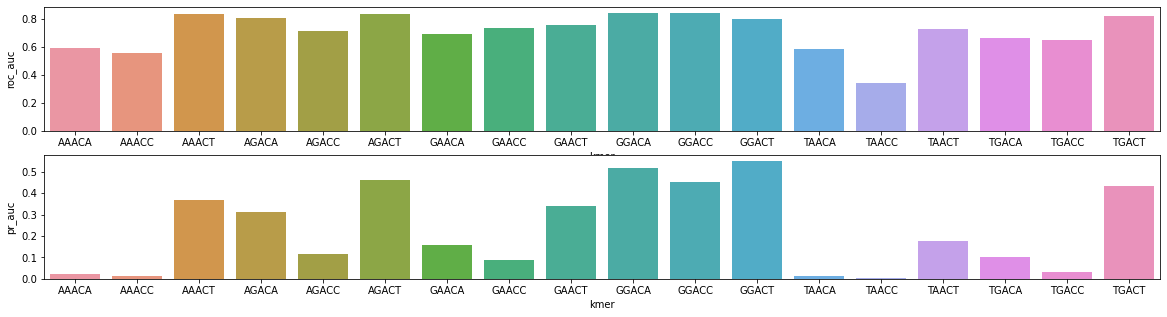

In [93]:
fig, axes = plt.subplots(2, 1, figsize=(20, 5))
kmers, counts = np.unique(result["kmer"], return_counts=True)

roc_aucs = []
pr_aucs = []

for kmer in kmers:
    kmer_df = result[result["kmer"] == kmer]
    roc_aucs.append(compute_roc_auc(kmer_df["modification_status"], kmer_df["probability_modified"]))
    pr_aucs.append(compute_pr_auc(kmer_df["modification_status"], kmer_df["probability_modified"]))

to_plot = pd.DataFrame({'kmer': kmers, 'roc_auc': roc_aucs, 'pr_auc': pr_aucs})
sns.barplot(x="kmer", y="roc_auc", data=to_plot, order=kmers, ax=axes[0])
sns.barplot(x="kmer", y="pr_auc", data=to_plot, order=kmers, ax=axes[1])